In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import auc

In [4]:
# Import results
path = "./results"
results = os.listdir(path)
results

['nnodes50-compl217-s1.csv']

In [5]:
# Plot one result
r_path = f"{path}/{results[0]}"
r = pd.read_csv(r_path)

error = r["error"]
power_bound = r["power_bound"]
power_BN = r["power_BN"]
power_CN = r["power_CN"]

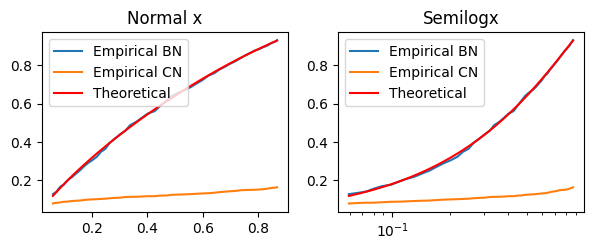

In [6]:
# Plot error vs power (empirical BN)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7, 7/3))
# ax2.set_xlim([1e-4, 0.2e1]) 
ax1.plot(error, power_BN, "-", label = 'Empirical BN')
ax2.semilogx(error, power_BN, "-", label = 'Empirical BN')

# Plot error vs power (empirical CN)
ax1.plot(error, power_CN, "-", label = 'Empirical CN')
ax2.semilogx(error, power_CN, "-", label = 'Empirical CN')

# Plot error vs power (theoretical)
ax1.plot(error, power_bound, "r-", label = 'Theoretical')
ax2.semilogx(error, power_bound, "r-", label = 'Theoretical')

# Plot info
ax1.set(title='Normal x')
ax2.set(title='Semilogx')

ax1.legend()
ax2.legend()

In [7]:
# Print results
r

,Unnamed: 0,error,threshold,power_bound,power_BN,power_CN
0,0,0.059475,-5.000000e-01,0.115402,0.124850,0.075630
1,1,0.066940,-4.800000e-01,0.127545,0.132053,0.078631
2,2,0.073682,-4.600000e-01,0.138297,0.139256,0.079832
3,3,0.079581,-4.400000e-01,0.147552,0.152461,0.079832
4,4,0.088611,-4.200000e-01,0.161465,0.166867,0.082233
5,5,0.098603,-4.000000e-01,0.176536,0.174070,0.084634
6,6,0.108837,-3.800000e-01,0.191650,0.191477,0.085234
7,7,0.119071,-3.600000e-01,0.206467,0.205282,0.087035
8,8,0.130628,-3.400000e-01,0.222875,0.216687,0.088836
9,9,0.141344,-3.200000e-01,0.237800,0.231092,0.090036


In [8]:
print(f"BN ROC: {auc(r['error'], r['power_BN'])}")
print(f"CN ROC: {auc(r['error'], r['power_CN'])}")

BN ROC: 0.46815200917834027
CN ROC: 0.0962374716320431
